# Solving master equations

Mostly this is setting up the system then using a 'general' purpose IVP solver, pyIVP, to solve them. We can also use the convenience 'spylind.mesolve' which mirrors the qutip 'mesolve' interface, with a couple of extra additions.

So this is mainly about testing ME solving. Categories of this to test here:

* Straight Optical Bloch Equations (OBEs). This is zero-dimensional, and should be very similar to using qutip
* Time dependent terms with time dependece defined numerically.
* OBEs in parallel: Simulate lots of independent OBEs at once, by adding a detuning axis or similar.
* OBEs with some state depnence: 1D, SVEA 1-way MBEs, 
* OBEs with time and space dependnet parameters (e.g. gradient echo) <- TODO
* SVEA 2-way (and cavities) <- TODO


Major TODOs: 
* Make a cleaner seperation between defining/compiling the model and running it. This requires a way of defning a simulation's parameters
* Enable seamless use of Tensorflow instead of numpy
    * Make sure to use optmised MKL version of tensorflow (anacodna: should arrive once TF 2.2 makes it to anaconda)
    * have it do automatic differentiation.
    * Make it run on the GPU
* Simulate a pair of interacting atoms
* SERF regime simulation 


# Initialisation

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
from spylind import spyIVP as so
import sympy as sm

from spylind import spylind as h # master equation useful bits
import qutip as q
sm.init_printing()

# For testing/debugging:
if 1:
    import pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# OBEs only
Use it as close to qutip-style as possible. Make bloch equations, make symbollic expressions, and solve numerically

## 0D (no detuning or space)

### 2- level

In [1]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS = sm.symbols('t', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 1*K2*K2.dag()
c_opL = [sqrt(.1)*q.sigmam()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()] ]
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)
display("Bloch equations:")
display(eq)

ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES_r, ES_i])
ode_s.set_driving({ES_r: lambda t: -1*t**2, ES_i: lambda t: 0*-1*t**2})
ode_s.set_initial_conditions(np.array([1,0,0]) )
ode_s.setup()

tSteps = linspace(0,10,1000)
out=ode_s.integrate(tSteps, 1.0)
state_res = np.array(ode_s.outputL).squeeze()
plot(tSteps,  state_res.real )
plot(tSteps,  state_res.imag[:,-1] )

legend(ode_s.symsD['prop_state_syms'])

NameError: name 'q' is not defined

In [5]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS = sm.symbols('t', real=True)
ES = sm.symbols("E", complex=True)
H0 = 1*K2*K2.dag()
sig_p = K1*K2.dag() #+ K2*K1.dag() 
c_opL = [sqrt(.1)*K1*K2.dag()]

H_desc = [H0, [ES, sig_p], [sm.conjugate(ES), sig_p.dag()]]
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [sig_p], bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)
#(diagL,diag_dtL), (cohL, coh_dtL), e_op_L = h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1])
display("Bloch equations:")
display(eq)
display("Expectation of polarisation:")
display(ex_vals)

'Bloch equations:'

⎡\rho_{0|0}  \rho_{0|1}⎤   ⎡                                                  
⎢                      ⎥   ⎢      1.0⋅ⅈ⋅E⋅\rho_{0|1} + 0.1⋅\rho_{1|1} - 1.0⋅ⅈ⋅
⎢__________            ⎥ = ⎢                                                  
⎣\rho_{0|1}  \rho_{1|1}⎦   ⎢                                                  
                           ⎣-1.0⋅ⅈ⋅E⋅\rho_{0|0} + 1.0⋅ⅈ⋅E⋅\rho_{1|1} + (-0.05 

_ __________                          _                                       
E⋅\rho_{0|1}         1.0⋅ⅈ⋅\rho_{0|0}⋅E + \rho_{0|1}⋅(-0.05 + 1.0⋅ⅈ) - 1.0⋅ⅈ⋅\
                                                                              
         __________                                                    _ _____
- 1.0⋅ⅈ)⋅\rho_{0|1}       -1.0⋅ⅈ⋅E⋅\rho_{0|1} - 0.1⋅\rho_{1|1} + 1.0⋅ⅈ⋅E⋅\rho_

          _⎤
rho_{1|1}⋅E⎥
           ⎥
_____      ⎥
{0|1}      ⎦

'Expectation of polarisation:'

In [6]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES])
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_state_dep_funcs({})
ode_s.set_initial_conditions(np.array([1,0,0]) )
ode_s.setup()

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': []})
state dependent functions should have signature [t, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E]


Not integrating first step (it's just the initial state)
CPU times: user 901 ms, sys: 6 ms, total: 907 ms
Wall time: 1.01 s


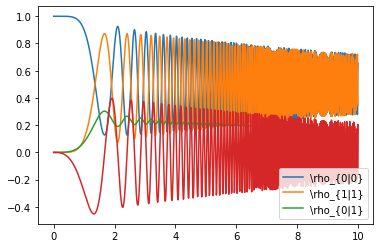

In [7]:
tSteps = linspace(0,10,1000)
%time out=ode_s.integrate(tSteps, 1.0)
res_state = np.array(ode_s.outputL).squeeze()
plot(tSteps,  res_state.real )
plot(tSteps,  res_state[:,-1].imag )

legend(ode_s.symsD['prop_state_syms'])

 #### 2-level with Re-Im decomposition
 Same as above but decompose complex elements to real-imaginary parts first. This can be done automatically as long as the symbols are defined appropriately (they'll be assumed complex unless expliticly defined as real)

In [32]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES], bDecompose_to_re_im=True)
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_initial_conditions(dict( zip(ode_s.symsD.prop_state_syms, [1,0,0,0]) ), bRealified=True )
ode_s.set_initial_conditions( [1,0,0], bRealified=False )
ode_s.setup()

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': [E^i, E^r]})
state dependent functions should have signature <itertools.chain object at 0x000002A04DBCB760>


Wall time: 127 ms


C:\Users\morgan\Anaconda3\envs\pymbe\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\morgan\Anaconda3\envs\pymbe\lib\site-packages\scipy\integrate\_ode.py:1004: ComplexWarning: Casting complex values to real discards the imaginary part
  y1, t, istate = self.runner(*args)


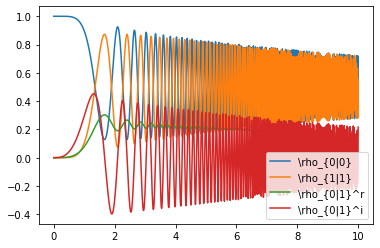

In [33]:
tSteps = linspace(0,10,1000)
%time out=ode_s.integrate(tSteps, 1.0)

plot(tSteps,  np.array(ode_s.outputL).squeeze() )
#plot(tSteps,  np.array(ode_s.outputL).squeeze().imag )

legend(ode_s.symsD['prop_state_syms'])

#### Comparison with qutip
How we'd do the same simulation in qutip. It's not really 'fair' speed wise because this could be made somewhat faster quite easily. It's a good check of results though

Wall time: 71.2 ms


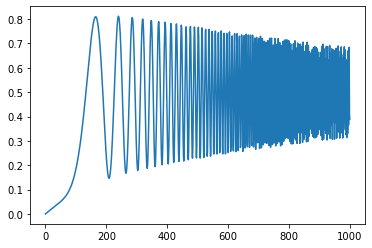

In [11]:
H0 = 1*K2*K2.dag()
H1 = K1*K2.dag() #+ K2*K1.dag() 
c_opL = [sqrt(.1)*K1*K2.dag()]
%time res=q.mesolve([ [H0, lambda t,_:1.0], [H1, lambda t,_: -t**2.0], [H1.dag(), lambda t,_: (-t**2.0).conjugate()]], K2, tSteps, c_ops = c_opL, e_ops=[K1*K1.dag()])
plot(res.expect[0])

### 3-level

In [13]:
K1, K2, K3 = q.basis(3,0), q.basis(3,1), q.basis(3,2)
tS, ES= sm.symbols('t, E')
H0 = 1*K2*K2.dag() + 2*K3*K3.dag()
H1 = K1*K2.dag() + K2*K1.dag() + K1*K3.dag() + K3*K1.dag()
c_opL = [sqrt(0.1)*K1*K2.dag(), sqrt(0.1)*K1*K3.dag()]
H_desc = [H0, [ES, H1]]
eq, expect_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1], bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)

display("Bloch equations:")
display(eq)
display("Polarisation:")
display(expect_vals)

makeMESymb enter


'Bloch equations:'

                                       ⎡                                      
⎡\rho_{0|0}  \rho_{0|1}  \rho_{0|2}⎤   ⎢-1.0⋅ⅈ⋅E⋅\rho_{0|1} - 1.0⋅ⅈ⋅E⋅\rho_{0|
⎢                                  ⎥   ⎢                                      
⎢__________                        ⎥   ⎢                                      
⎢\rho_{0|1}  \rho_{1|1}  \rho_{1|2}⎥ = ⎢             1.0⋅ⅈ⋅E⋅\rho_{0|0} - 1.0⋅
⎢                                  ⎥   ⎢                                      
⎢__________  __________            ⎥   ⎢                                      
⎣\rho_{0|2}  \rho_{1|2}  \rho_{2|2}⎦   ⎣             1.0⋅ⅈ⋅E⋅\rho_{0|0} - 1.0⋅

             __________           __________                                  
2} + 1.0⋅ⅈ⋅E⋅\rho_{0|1} + 1.0⋅ⅈ⋅E⋅\rho_{0|2} + 0.1⋅\rho_{1|1} + 0.1⋅\rho_{2|2}
                                                                              
                                                      __________              
ⅈ⋅E⋅\rho_{1|1} - 1.0⋅ⅈ⋅E⋅\rho_{1|2} + (-0.05 + 1.0⋅

'Polarisation:'

In [14]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES], bDecompose_to_re_im=False)
ode_s.set_driving({ES: lambda t: -2.0})
ode_s.set_initial_conditions([1,0,0,0,0,0])
ode_s.setup()

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': []})
state dependent functions should have signature [t, \rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}, E]


CPU times: user 442 ms, sys: 0 ns, total: 442 ms
Wall time: 544 ms


/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


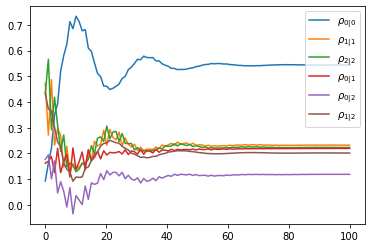

In [15]:
tSteps = linspace(0,100,100)
%time ode_s.integrate(tSteps,0.3)
plot(tSteps,  np.array(ode_s.outputL) )
legend(['${}$'.format(st) for st in  ode_s.symsD['prop_state_syms']]) # put $ signs around the symbols so they're rendered nicely

## OBEs with inhomogeneous broadening (introduce a detuning axis)
To do this we make three changes:

1. The coefficient for H0 is now a symbol, $\Delta$. 
2. We add an axis for $\Delta$ to the 'dims' argument when making an ODESolver, e.g. {DeltaS: linspace(-1,1,1000)}. 
3. We add an extra dimension when we set initial conditions (now it's got shape (3,1000))

### 2-level, large-ish inhomogeneous broadening

In [34]:
# Make the equations
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, DeltaS= sm.symbols('t,  Delta', real=True)
ES = sm.symbols("E", complex=True)
H0 = 1*K2*K2.dag()
H1 = K1*K2.dag() + K2*K1.dag() 
c_opL = [sqrt(0.3)*K1*K2.dag()]

H_desc = [0*H0, [DeltaS, H0], [ES, H1]]
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)
display("Bloch equations:")
display(eq)

makeMESymb enter


'Bloch equations:'

⎡\rho_{0|0}  \rho_{0|1}⎤   ⎡                                    __________    
⎢                      ⎥   ⎢      -1.0⋅ⅈ⋅E⋅\rho_{0|1} + 1.0⋅ⅈ⋅E⋅\rho_{0|1} + 0
⎢__________            ⎥ = ⎢                                                  
⎣\rho_{0|1}  \rho_{1|1}⎦   ⎢                                                  
                           ⎣1.0⋅ⅈ⋅E⋅\rho_{0|0} - 1.0⋅ⅈ⋅E⋅\rho_{1|1} + (1.0⋅ⅈ⋅Δ

                                                                              
.3⋅\rho_{1|1}        -1.0⋅ⅈ⋅E⋅\rho_{0|0} + 1.0⋅ⅈ⋅E⋅\rho_{1|1} + \rho_{0|1}⋅(-1
                                                                              
         __________                                      __________           
 - 0.15)⋅\rho_{0|1}         1.0⋅ⅈ⋅E⋅\rho_{0|1} - 1.0⋅ⅈ⋅E⋅\rho_{0|1} - 0.3⋅\rho

              ⎤
.0⋅ⅈ⋅Δ - 0.15)⎥
              ⎥
              ⎥
_{1|1}        ⎦

In [51]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ), tSym=tS,  dims={DeltaS: linspace(-3,3,1000)}, driving_syms=[ES])
ode_s.set_driving({ES: lambda t: 1.0})
#ode_s.set_state_dep_funcs({})
p0 = zeros( (3,1000) )
p0[1] = 1
ode_s.set_initial_conditions(p0)
ode_s.setup()

Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': [Delta]})
state dependent functions should have signature [t, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E]


In [53]:
tSteps = linspace(0,20,400)
%time ode_s.integrate(tSteps, max_step_size=1)
res= np.array(ode_s.outputL)
display(res.shape)

Wall time: 144 ms


C:\Users\morgan\Anaconda3\envs\pymbe\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\morgan\Anaconda3\envs\pymbe\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'atoms way off resonance')

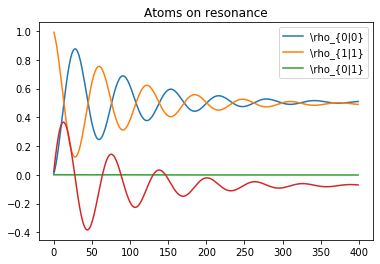

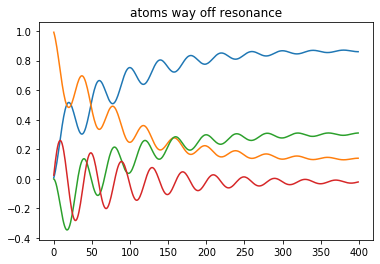

In [54]:
plot(  res[:,:,500] )
plot(  res[:,2,500].imag )
legend(ode_s.symsD['prop_state_syms'])
title("Atoms on resonance")
figure()
plot(  np.array(ode_s.outputL)[:,:,100] )
plot(  res[:,2,100].imag )
title("atoms way off resonance")

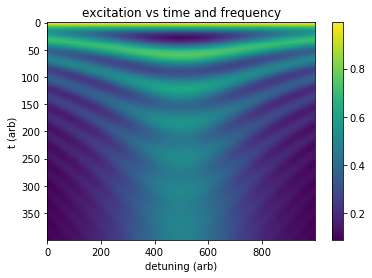

In [56]:
imshow(res[:,1].real, aspect='auto')
xlabel("detuning (arb)")
ylabel('t (arb)')
title('excitation vs time and frequency')
colorbar()

## OBEs with time and spatial dependence
Still no state-dependent evolution: i.e. it's essentially still just a parallel computation. No atom affects any other.
Here we do a time dependent detuning gradient (as would be done in a gradient echo)

In [133]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, DeltaS, zS, etaS = sm.symbols('t, Delta, z, eta', real=True) 
ES = sm.symbols('E', complex=True)
H0 = 1*K2*K2.dag()
H1 = K1*K2.dag() + K2*K1.dag() 
c_opL = [sqrt(0.02)*K1*K2.dag() ]
#c_opL = [L(op) for op in c_opL]

H_desc = [H0, [DeltaS, H0],[zS*etaS, H0], [ES, H1]]
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)
display("Bloch equations:")
display(eq)

________________________________________________________________________________
[Memory] Calling helper.makeMESymb...
makeMESymb([ Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]],
  [ Delta,
    Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]],
  [ eta*z,
    Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]],
  [ E,
    Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]]], c_opL=[ Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.       0.141421]
 [0.       0.      ]]], bReturnMatrixEquation=True)
makeEvolutionSymbols enter
_______________________________________________________makeMESymb - 0.5s, 0.0min


'Bloch equations:'

⎡\rho_{0|0}  \rho_{0|1}⎤   ⎡                                             _____
⎢                      ⎥   ⎢               -1.0⋅ⅈ⋅E⋅\rho_{0|1} + 1.0⋅ⅈ⋅E⋅\rho_
⎢__________            ⎥ = ⎢                                                  
⎣\rho_{0|1}  \rho_{1|1}⎦   ⎢                                                  
                           ⎣1.0⋅ⅈ⋅E⋅\rho_{0|0} - 1.0⋅ⅈ⋅E⋅\rho_{1|1} + (1.0⋅ⅈ⋅Δ

_____                                                                         
{0|1} + 0.02⋅\rho_{1|1}                  -1.0⋅ⅈ⋅E⋅\rho_{0|0} + 1.0⋅ⅈ⋅E⋅\rho_{1
                                                                              
                             __________                                       
 + 1.0⋅ⅈ⋅η⋅z - 0.01 + 1.0⋅ⅈ)⋅\rho_{0|1}                   1.0⋅ⅈ⋅E⋅\rho_{0|1} -

                                                      ⎤
|1} + \rho_{0|1}⋅(-1.0⋅ⅈ⋅Δ - 1.0⋅ⅈ⋅η⋅z - 0.01 - 1.0⋅ⅈ)⎥
                                                      ⎥
         __________                     

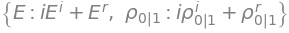

Munch({'tSym': t, 'dimSyms': [Delta, z], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E, eta], 'state_dep_syms': [z, E^i, Delta, E^r]})
state dependent functions should have signature <itertools.chain object at 0x718e3a93bf28>


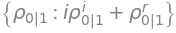

CPU times: user 5.29 s, sys: 106 ms, total: 5.4 s
Wall time: 4.6 s


In [134]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS: linspace(-30,30,100), zS: linspace(-1,1,30)}, driving_syms=[ES, etaS], bDecompose_to_re_im=True)
ode_s.set_driving({ES: lambda t: -2.0,
                  etaS: lambda t: -1 if t<5 else 1})

#ode_s.set_state_dep_funcs({})
p0 = zeros( (3,100,30) )
p0[0] = 1
ode_s.set_initial_conditions(p0)
ode_s.setup()#prepare_for_integration()
tSteps = linspace(0,10,1000)
%time ode_s.integrate(tSteps)

'result dimension: '

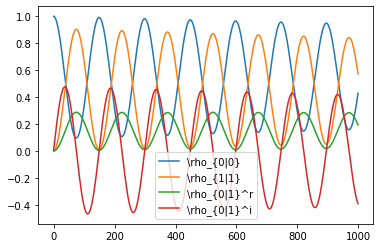

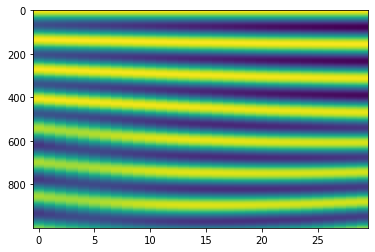

In [137]:
arr = np.array(ode_s.outputL)
display("result dimension: ", arr.shape)
plot(  arr[:,:,50, 15] )
legend(ode_s.symsD['prop_state_syms'])
figure()
imshow(  arr[:,0,50].real, aspect='auto' )

## Excitation-dependent decay rate
Decay that depends on how much population is in the excited state. This is a 'state-dependent' simulation.

The example below will change the decay-rate sharply when the excitated state population drops below a certain level.

In [24]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS,  gS= sm.symbols('t,  gamma', real=True)
ES = sm.symbols("E", complex=True)
H0 = 1*K2*K2.dag()
H1 = K1*K2.dag() + K2*K1.dag() 
c_opL = [[gS, K1*K2.dag() ]]
#c_opL = [sqrt(0.1)*K1*K2.dag()]
H_desc = [H0, [ES, H1]]
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1], bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)
display(eq)

makeEvolutionSymbols enter


⎡\rho_{0|0}  \rho_{0|1}⎤   ⎡                                   __________     
⎢                      ⎥   ⎢     -1.0⋅ⅈ⋅E⋅\rho_{0|1} + 1.0⋅ⅈ⋅E⋅\rho_{0|1} + 1.
⎢__________            ⎥ = ⎢                                                  
⎣\rho_{0|1}  \rho_{1|1}⎦   ⎢                                                  
                           ⎣1.0⋅ⅈ⋅E⋅\rho_{0|0} - 1.0⋅ⅈ⋅E⋅\rho_{1|1} + (-0.5⋅γ 

                                                                              
0⋅\rho_{1|1}⋅γ       -1.0⋅ⅈ⋅E⋅\rho_{0|0} + 1.0⋅ⅈ⋅E⋅\rho_{1|1} + \rho_{0|1}⋅(-0
                                                                              
         __________                                     __________            
+ 1.0⋅ⅈ)⋅\rho_{0|1}        1.0⋅ⅈ⋅E⋅\rho_{0|1} - 1.0⋅ⅈ⋅E⋅\rho_{0|1} - 1.0⋅\rho_

             ⎤
.5⋅γ - 1.0⋅ⅈ)⎥
             ⎥
             ⎥
{1|1}⋅γ      ⎦

In [23]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES])
ode_s.set_driving({ES: lambda t: -0.0})
def gF(t, dimAxs,state,driving):
    rho11 = state[1]
    return sqrt(0.01) if rho11>0.4 else sqrt(0.0001)
    
ode_s.set_state_dep_funcs({gS:gF })
ode_s.set_initial_conditions([0,1,0])
ode_s.setup()

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': [gamma]})
state dependent functions should have signature [t, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E]


/home/morgan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


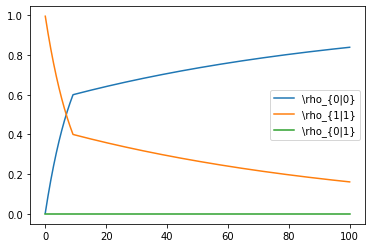

In [25]:
tSteps = linspace(0,100,1000)
ode_s.integrate(tSteps, 1.0)
plot(tSteps,  np.array(ode_s.outputL).squeeze() )
legend(ode_s.symsD['prop_state_syms'])

## Interacting atoms (i.e. satellite lines)
A pair of interaction quantum systems at each 'site'.
It would be good if we could introduce a different labelling convention for the density matrix here.

Define product states in the usual way one does in qutip. Here we're just doing 2 2-level system. We're using 'a' to represent an optical decay operator. That's mostly because it's easy to write, and it is something like an annihilation operator. The other option would be to write it as $\sigma_-$, but that's not quite right either

In [3]:
def K(state1, state2):
    return T(q.basis(2,state1), q.basis(2,state2) )

In [32]:
T = q.tensor
# DEFINE OPERATORS
_ID = q.qeye(2) #Identity operator
_a = q.basis(2,0)*q.basis(2,1).dag() # |0><1| (Single atom decay from excited state to ground state
a1 = T(_a, _ID) 
a2 = T(_ID, _a)
a_both = T(_a, _a) #Lower both atoms
N1 = a1.dag()*a1 #Number operators for site 1
N2 = a2.dag()*a2 #Number operator for site 2
N_both = a_both.dag()*a_both #Number operator for the site

H0 = 0*N1 + 0*N2  
Hint = N_both
H1 = (a1 + a2) # Interaction with the field
T1 = 100.
c_opL = [sqrt(1./T1)*a1, sqrt(1./T1)*a2]

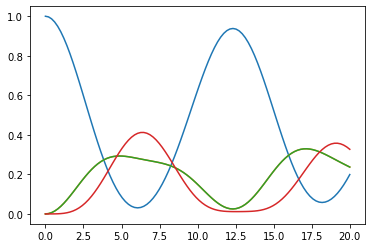

In [33]:
#QUTIP
tSteps = linspace(0,20,100)
res=q.mesolve( [[H1, lambda t,_: -0.2],  [H1.dag(), lambda t,_: conjugate(-0.2)], [Hint, lambda t,_: 0.5]], K(0,0), tlist=tSteps, c_ops=c_opL, e_ops=[ket*ket.dag() for ket in Hint.eigenstates()[1]])
plot(tSteps, array(res.expect).T)

In [42]:
#Construct the symbollic simulation
tS, etaS = sm.symbols('t, eta', real=True)
ES = sm.symbols("E", complex=True)
H_desc = [H0, [ES, H1], [sm.conjugate(ES), H1.dag()], [etaS, Hint]]
rhoS = h.getTensoredRhoS('01', 'ab') #Setting nice symbol labels for the density matrix will make it easier to interpret results
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1], bReturnMatrixEquation=True, rhoS=rhoS)
lhsL, rhsL = h.seperate_DM_equation(eq)
#(diagL,diag_dtL), (cohL, coh_dtL), e_op_L = h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1])
display("Bloch equations:")
display(eq)

makeEvolutionSymbols enter


'Bloch equations:'

⎡\rho_{00|aa}  \rho_{00|ba}  \rho_{10|aa}  \rho_{10|ba}⎤   ⎡                  
⎢                                                      ⎥   ⎢-1.0⋅ⅈ⋅E⋅\rho_{00|
⎢____________                                          ⎥   ⎢                  
⎢\rho_{00|ba}  \rho_{00|bb}  \rho_{10|ab}  \rho_{10|bb}⎥   ⎢                  
⎢                                                      ⎥   ⎢1.0⋅ⅈ⋅E⋅\rho_{00|a
⎢____________  ____________                            ⎥ = ⎢                  
⎢\rho_{10|aa}  \rho_{10|ab}  \rho_{11|aa}  \rho_{11|ba}⎥   ⎢                  
⎢                                                      ⎥   ⎢1.0⋅ⅈ⋅E⋅\rho_{00|a
⎢____________  ____________  ____________              ⎥   ⎢                  
⎣\rho_{10|ba}  \rho_{10|bb}  \rho_{11|ba}  \rho_{11|bb}⎦   ⎢            ______
                                                           ⎣    1.0⋅ⅈ⋅E⋅\rho_{

                                                                           _ _
ba} - 1.0⋅ⅈ⋅E⋅\rho_{10|aa} + 0.01⋅\rho_{00|bb} + 0.

In [48]:
np.ravel(K(0,0)*K(0,0).dag())

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [55]:
ode_s.symsD_orig.prop_state_syms

In [57]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES, etaS], bDecompose_to_re_im=True)
#ode_s.set_state_dep_funcs({})
ode_s.set_initial_conditions([1.] + (len(ode_s.symsD_orig.prop_state_syms)-1)*[0])


ode_s.set_driving({ES: lambda t: -0.2, etaS: .5})
ode_s.setup()

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [\rho_{00|aa}, \rho_{00|bb}, \rho_{11|aa}, \rho_{11|bb}, \rho_{00|ba}^r, \rho_{00|ba}^i, \rho_{10|aa}^r, \rho_{10|aa}^i, \rho_{10|ba}^r, \rho_{10|ba}^i, \rho_{10|ab}^r, \rho_{10|ab}^i, \rho_{10|bb}^r, \rho_{10|bb}^i, \rho_{11|ba}^r, \rho_{11|ba}^i], 'stationary_state_syms': [], 'driving_syms': [E, eta], 'state_dep_syms': [E^i, E^r]})
state dependent functions should have signature <itertools.chain object at 0x00000225E8AA6970>


Wall time: 17.9 ms


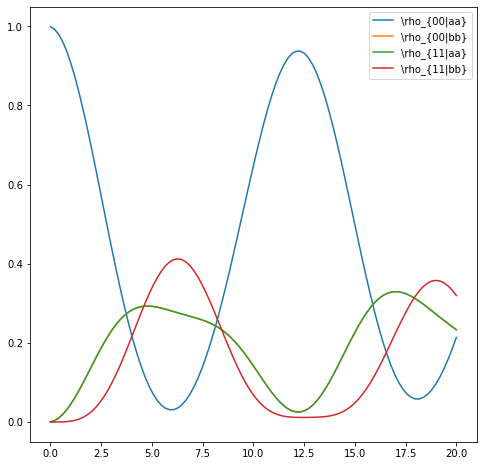

In [58]:
tSteps = linspace(0,20,100)
%time ode_s.integrate(tSteps, 1.0)
arr = np.array(ode_s.outputL).squeeze() 
figure(figsize=(8,8))
plot(tSteps, arr[:,:4] )
#plot(tSteps,  arr.imag )
#ylim([-0.2, 0.5])
legend(ode_s.symsD['prop_state_syms'][:4], loc='best')

In [45]:
arr.shape

### Using a range of interaction strengths

In [37]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={etaS: linspace(0,1,100)}, driving_syms=[ES], bDecompose_to_re_im=True)
#ode_s.set_state_dep_funcs({})
initial_state = np.tile(np.array([1,0,0,0, 0, 0, 0, 0, 0, 0]), (100,1) ).T

ode_s.set_initial_conditions(initial_state)
ode_s.set_driving({ES: lambda t: -1.0})
ode_s.setup()

Munch({'tSym': t, 'dimSyms': [eta], 'prop_state_syms': [\rho_{00|aa}, \rho_{00|bb}, \rho_{11|aa}, \rho_{11|bb}, \rho_{00|ba}^r, \rho_{00|ba}^i, \rho_{10|aa}^r, \rho_{10|aa}^i, \rho_{10|ba}^r, \rho_{10|ba}^i, \rho_{10|ab}^r, \rho_{10|ab}^i, \rho_{10|bb}^r, \rho_{10|bb}^i, \rho_{11|ba}^r, \rho_{11|ba}^i], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': [E^i, E^r, eta]})
state dependent functions should have signature <itertools.chain object at 0x00000225EA7D3250>


Wall time: 383 ms


Text(0.5, 1.0, 'Excitation vs time and interaction strength')

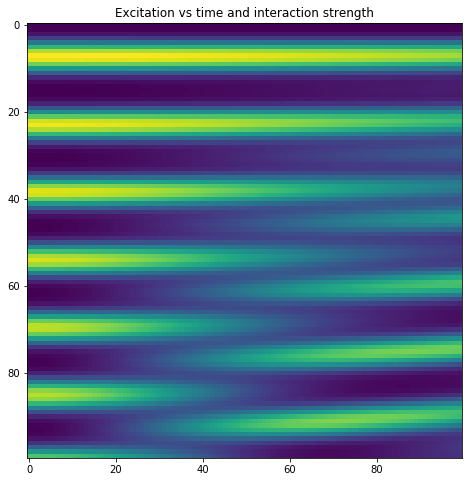

In [39]:
tSteps = linspace(0,20,100)
%time ode_s.integrate(tSteps, 1.0)
arr = np.array(ode_s.outputL).squeeze() 
figure(figsize=(8,8))
imshow(arr[:,3].real)
title('Excitation vs time and interaction strength')
#plot(tSteps, arr )
#plot(tSteps,  arr.imag )
#ylim([-0.2, 0.5])
#legend(ode_s.symsD['prop_state_syms'], loc='best')

# State dependent examples
Now the evolution can depend on state- so atoms can affect each other. Now we have to define dependence on other axes and use "set_state_dep_funcs" to tell it to symODE.

## 1-way MBEs 
E-field seen by the atoms is now split as $E = E_{ex} + E_{int}$. The former ($E_ex$) is that due to the external field, that is incidenct on the cavity. $E_int$ is that due to the polarisation of the atoms. The driving field is $E_{ex}$, while $E_{int}$ is the internally calculated, state-dependent field. 

In [149]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS = sm.symbols('t, z', real=True)
EexS,EintS, EtotS = sm.symbols('E_ex, E_int, E_tot', complex=True)
E_subs_D = {EtotS: EexS + EintS}
H0 = 0*K2*K2.dag()
H1a = K2*K1.dag() 
H1b = K1*K2.dag()
sx=K2*K1.dag() + K1*K2.dag()
sy=1j*K2*K1.dag() - 1j*K1*K2.dag()
c_opL = [sqrt(1)*K1*K2.dag() ]
H_desc = [H0, [EexS+EintS, H1a], [sm.conjugate(EexS) + sm.conjugate(EintS), H1b]]
H_desc = [H0, [EtotS, H1a], [sm.conjugate(EtotS), H1b]]

eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1a], bReturnMatrixEquation=True)
display(eq, ex_vals)

________________________________________________________________________________
[Memory] Calling helper.makeMESymb...
makeMESymb([ Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 0.]],
  [ E_tot,
    Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]],
  [ conjugate(E_tot),
    Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]]], c_opL=[ Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]], e_opL=[ Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]], bReturnMatrixEquation=True)
makeEvolutionSymbols enter
_______________________________________________________makeMESymb - 0.4s, 0.0min


⎡\rho_{0|0}  \rho_{0|1}⎤   ⎡           __________                    ____     
⎢                      ⎥   ⎢1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{0|1} - 1.0⋅ⅈ⋅\rho_{0|1}⋅Eₜₒₜ + 1.
⎢__________            ⎥ = ⎢                                                  
⎣\rho_{0|1}  \rho_{1|1}⎦   ⎢                 ____                    ____     
                           ⎣1.0⋅ⅈ⋅\rho_{0|0}⋅Eₜₒₜ - 1.0⋅ⅈ⋅\rho_{1|1}⋅Eₜₒₜ - 0.

                                                                              
0⋅\rho_{1|1}  -1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{0|0} + 1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{1|1} - 0.5⋅\rho_{0|1} 
                                                                              
  __________               __________                    ____                 
5⋅\rho_{0|1}  - 1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{0|1} + 1.0⋅ⅈ⋅\rho_{0|1}⋅Eₜₒₜ - 1.0⋅\rho_{1|1}

⎤
⎥
⎥
⎥
⎦

In [150]:
nDims = len(ode_s.state_shape)-1
nStates = ode_s.state_shape[0]
nDriving = len(ode_s.symsD.driving_syms)
def wrapped1(*args):
    t = args[0]
    k=1
    
    dimAxs = args[k:k+nDims]
    k+=nDims
    
    state = args[k:k+nStates]
    k+=nStates
    
    driving = args[k:k+nDriving]
    
    return calcPolFields(t, dimAxs,state, driving)

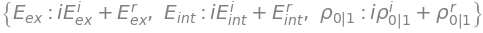

Munch({'tSym': t, 'dimSyms': [z], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E_ex], 'state_dep_syms': [E_ex^r, E_int^r, E_int^i, E_ex^i]})
state dependent functions should have signature <itertools.chain object at 0x718e33554e10>


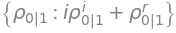

In [151]:
lhsL, rhsL = h.seperate_DM_equation(eq.subs(E_subs_D))
pol_exp = ex_vals[0].subs(E_subs_D)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={zS: linspace(0,1,100)}, driving_syms=[EexS], bDecompose_to_re_im=True)
if 1:
    #pol_exp=pol_exp.subs(ode_s.complex_subsD)
    polF=sm.lambdify( ode_s.symsD_orig['prop_state_syms'],pol_exp, dummify=True)
else:
    polF=sm.lambdify( ode_s.symsD['prop_state_syms'],pol_exp, dummify=True)

zAx = ode_s.dimAxes[0]
dz = zAx[1]-zAx[0]

#def calcPolFieldF(t, z,rho00, rho11, rho01,Eex):
def calcPolFieldF(t, dimAxs,state,driving):
    #pdb.set_trace()
    pol = polF(*state)
    #P = -1j*np.cumsum(polF(rho00, rho11, rho01))*dz*1
    P = -1j*np.cumsum(polF(*state))*dz*1
    #print(state[2].sum()) 
 
    return P
calcPolFieldF.num=0

ode_s.set_driving({EexS: lambda t: -0.5 if t<20 else 0})
ode_s.set_state_dep_funcs({EintS:calcPolFieldF})
ode_s.set_initial_conditions(np.tile(array([1,0,0]), (100,1) ).T.astype('c16'))
ode_s.setup()

CPU times: user 119 ms, sys: 5 ms, total: 124 ms
Wall time: 149 ms


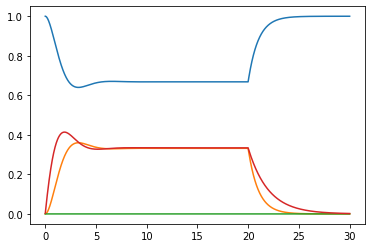

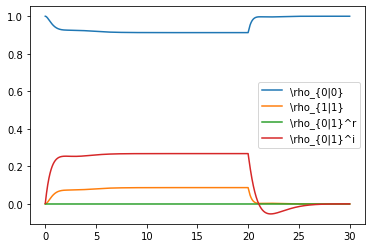

In [152]:
tSteps = linspace(0,30,2000)
%time ode_s.integrate(tSteps, 0.1)
arr =np.array(ode_s.outputL)
figure()
plot(tSteps,  arr[:,:,0].squeeze() )
figure()
plot(tSteps,  arr[:,:,-1].squeeze() )
legend(ode_s.symsD['prop_state_syms'])

In [86]:
%debug

> /home/morgan/anaconda3/lib/python3.7/bdb.py(113)dispatch_line()
    111         if self.stop_here(frame) or self.break_here(frame):
    112             self.user_line(frame)
--> 113             if self.quitting: raise BdbQuit
    114         return self.trace_dispatch
    115 

ipdb> q


CPU times: user 125 ms, sys: 2 ms, total: 127 ms
Wall time: 138 ms


/home/morgan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


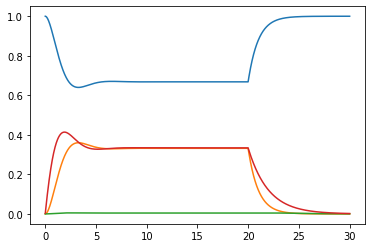

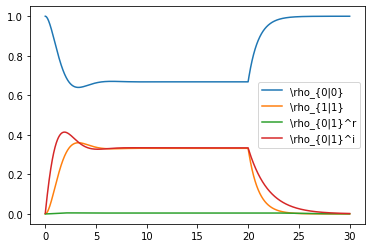

In [35]:
tSteps = linspace(0,30,2000)
%time ode_s.integrate(tSteps, 0.1)
arr =np.array(ode_s.outputL)
figure()
plot(tSteps,  arr[:,:,0].squeeze() )
figure()
plot(tSteps,  arr[:,:,-1].squeeze().real )

legend(ode_s.symsD['prop_state_syms'])

Text(0.5, 1.0, 'excitation')

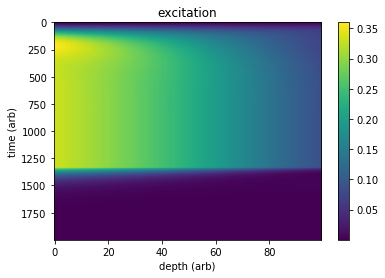

In [155]:
imshow(arr[:,1].real, aspect='auto')
colorbar()
xlabel('depth (arb)')
ylabel('time (arb)')
title('excitation')

## 1-way MBEs with inhomogenous broadening

## 2 way SVEA MBEs
Work in progress

In [26]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS = sm.symbols('t, z', real=True)
EexS,EintS, EtotS = sm.symbols('E_ex, E_int, E_tot', complex=True)
E_subs_D = {EtotS: EexS + EintS}
H0 = 0*K2*K2.dag()
H1a = K2*K1.dag() 
H1b = K1*K2.dag()
sx=K2*K1.dag() + K1*K2.dag()
sy=1j*K2*K1.dag() - 1j*K1*K2.dag()
c_opL = [sqrt(1)*K1*K2.dag() ]
H_desc = [H0, [EtotS, H1a], [sm.conjugate(EtotS), H1b]]

eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1a], bReturnMatrixEquation=True)
display(eq, ex_vals)

⎡\rho_{0|0}  \rho_{0|1}⎤   ⎡           __________                    ____     
⎢                      ⎥   ⎢1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{0|1} - 1.0⋅ⅈ⋅\rho_{0|1}⋅Eₜₒₜ + 1.
⎢__________            ⎥ = ⎢                                                  
⎣\rho_{0|1}  \rho_{1|1}⎦   ⎢                 ____                    ____     
                           ⎣1.0⋅ⅈ⋅\rho_{0|0}⋅Eₜₒₜ - 1.0⋅ⅈ⋅\rho_{1|1}⋅Eₜₒₜ - 0.

                                                                              
0⋅\rho_{1|1}  -1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{0|0} + 1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{1|1} - 0.5⋅\rho_{0|1} 
                                                                              
  __________               __________                    ____                 
5⋅\rho_{0|1}  - 1.0⋅ⅈ⋅Eₜₒₜ⋅\rho_{0|1} + 1.0⋅ⅈ⋅\rho_{0|1}⋅Eₜₒₜ - 1.0⋅\rho_{1|1}

⎤
⎥
⎥
⎥
⎦

In [ ]:
lhsL, rhsL = h.seperate_DM_equation(eq.subs(E_subs_D))
pol_exp = ex_vals[0].subs(E_subs_D)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={zS: linspace(0,1,100)}, driving_syms=[EexS], bDecompose_to_re_im=False)
polF=sm.lambdify( ode_s.symsD['prop_state_syms'],pol_exp, dummify=True)
zAx = ode_s.dimAxes[0]
dz = zAx[1]-zAx[0]


#fwMode =
#rvMode = 
#M = 
# eps = 

#def calcPolFieldF(t, z,rho00, rho11, rho01,Eex):
def calcPolFieldFwRv(t, dimAxs,state,driving, excArrs):
    pol = polF(*state)
    #pol*= lineShape #When inhomogeneously broadened
    #pol = pol.sum(axis=-1)
    EpolFw[:] = np.cumsum(pol * excArrs.fwMode.conj())
    EpolRv[:] = np.cumsum( (pol * excArrs.rvMode.conj())[::-1] )[::-1]
    excitedModes = excArrs.M.dot(
            np.array([EinFwNow, EinRvNow, -1j*EpolFw[-1]*eps, -1j*EpolRv[0]*eps]))
    if bRetModesOnly:
        return excitedModes
    #Else, calculate the spatial field too
    Etot[:] = -1j*EpolFw * excArrs.fwMode + -1j*EpolRv * excArrs.rvMode + \
         excitedModes[2] * excArrs.fwMode + excitedModes[3] * excArrs.rvMode

    #P = -1j*np.cumsum(polF(rho00, rho11, rho01))*dz*1
    P = -1j*np.cumsum(polF(*state))*dz*1
    return P
calcPolFieldF.num=0

ode_s.set_driving({EexS: lambda t: -0.5 if t<20 else 0})
ode_s.set_state_dep_funcs({EintS:calcPolFieldF})
ode_s.set_initial_conditions(np.tile(array([1,0,0]), (100,1) ).T.astype('c16'))
ode_s.setup()

CPU times: user 112 ms, sys: 12 ms, total: 124 ms
Wall time: 125 ms


/home/morgan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


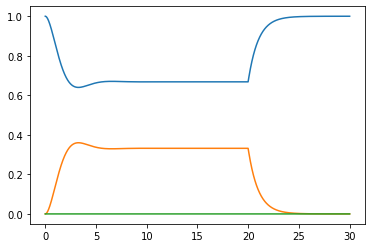

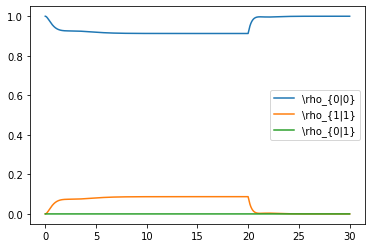

In [28]:
tSteps = linspace(0,30,2000)
%time ode_s.integrate(tSteps, 0.1)
arr =np.array(ode_s.outputL)
figure()
plot(tSteps,  arr[:,:,0].squeeze() )
figure()
plot(tSteps,  arr[:,:,-1].squeeze().real )

legend(ode_s.symsD['prop_state_syms'])

# Spatial dependent examples

## GEM (WIP)


In [18]:
K1.shape

(2, 1)

# Scrap

# Copying pyMBE (WIP)

Will use spl.makeBlochOperators to mimic the old pyMBE examples (non-spatial dependent). Spatial dependence may be added as shown above.

First make the operators (same arguments as pyMBE).
Note that the returned driving operator ("dest") is a non-Hermition lowering operator now. in pyMBE it's dest.dag()*dest

In [ ]:
#
H0, [EinS, dest], [DeltaS, Hdet], c_opL=h.makeBlochOperators(gsEnergies= [0,1], esEnergies=[0], osc_strengths=np.array([[1],[1]]) ,
                        T1_opt=2)
H_desc = [H0, (EinS, dest), (sm.conjugate(EinS), dest.H), (DeltaS, Hdet) ]


Make the equations of motion

In [176]:
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [dest], bReturnMatrixEquation=True)
display(eq, ex_vals)

                                       ⎡                                      
                                       ⎢                                 __   
⎡\rho_{0|0}  \rho_{0|1}  \rho_{0|2}⎤   ⎢             1.0⋅ⅈ⋅Ef⋅\rho_{0|2}⋅Ef + 
⎢                                  ⎥   ⎢                                      
⎢__________                        ⎥   ⎢                              ⎛       
⎢\rho_{0|1}  \rho_{1|1}  \rho_{1|2}⎥ = ⎢                         __   ⎜       
⎢                                  ⎥   ⎢     1.0⋅ⅈ⋅Ef⋅\rho_{1|2}⋅Ef + ⎝- 0.5⋅ⅈ
⎢__________  __________            ⎥   ⎢                                      
⎣\rho_{0|2}  \rho_{1|2}  \rho_{2|2}⎦   ⎢                                      
                                       ⎢                      __              
                                       ⎣- 1.0⋅ⅈ⋅Ef⋅\rho_{0|0}⋅Ef + 1.0⋅ⅈ⋅Ef⋅\r

                 ⎛                      2⎞                                    
                 ⎜          2         __ ⎟ ________

Define the simulation

In [198]:
detAx = linspace(-1,1,50)
tSteps = linspace(0,10,1000)
EinFw = lambda t: .5 + 0.0j if (t>1) and (t<3) else 0
lhsL, rhsL = h.seperate_DM_equation(eq)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ), dims={DeltaS:detAx }, backend='numpy')
p0 = zeros(ode_s.state_shape)
p0[0] = 1. #Start everything in the first ground state
ode_s.set_driving({EinS:EinFw})
ode_s.set_initial_conditions(p0)
ode_s.setup()


Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [Delta, Ef]})
state dependent functions should have signature [t, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}]


Not integrating first step (it's just the initial state)
CPU times: user 370 ms, sys: 2 ms, total: 372 ms
Wall time: 372 ms


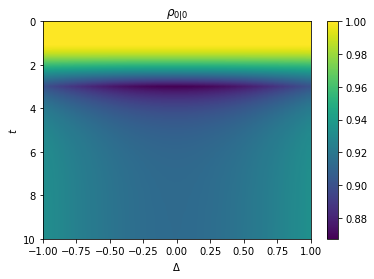

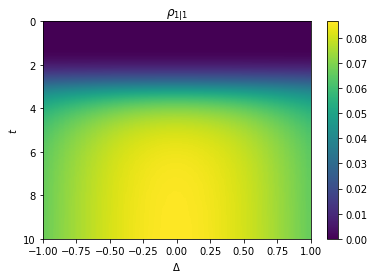

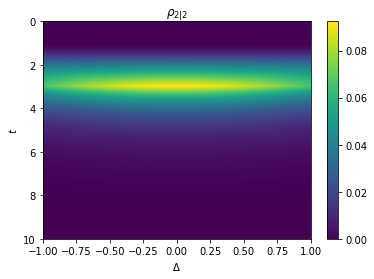

In [199]:
%time ode_s.integrate(tSteps, 0.01)
outA = np.array(ode_s.outputL).copy()
for k in range(3):
    figure()
    imshow(outA[:,k,:].real, aspect='auto', extent=[detAx[0], detAx[-1], tSteps[-1], tSteps[0]])

    xlabel(r"$\Delta$")
    ylabel('$t$')
    colorbar()
    title(r'${}$'.format(lhsL[k]) )

In [200]:
p0.shape

In [149]:
from scipy import interpolate
def EinFwF(t):
    return EinFwF.intp(t)
#interpolate.interp1d?

In [147]:
EinA[:] = np.where( (tAx>0) & (tAx<1), 1.0, 0 )*1
EinIntp  =interpolate.interp1d(tAx, EinA, copy=False)
EinFwF.intp = EinIntp
display(EinFwF(0.5))

EinA[:] = np.where( (tAx>0) & (tAx<1), 1.0, 0 )*5
display(EinIntp(.5))

array(1.)

array(1.)

In [165]:
tAx = linspace(-0.1,10.1,1000)
EinA = np.where( (tAx>1) & (tAx<5), 1.0, 0 )*1e-5
EinIntp  =interpolate.interp1d(tAx, EinA)
def EinFwF(t):
    return EinFwF.intp(t)
EinFwF.intp = EinIntp

ode_s.set_driving({EinS:EinFwF})
%time ode_s.setup() 
%time ode_s.integrate(tSteps, 0.01)
outA1 = np.array(ode_s.outputL).copy()

EinA[:] = np.where( (tAx>0) & (tAx<np.pi), 1.0, 0 )*1
EinIntp  =interpolate.interp1d(tAx, EinA, copy=False)
EinFwF.intp = EinIntp
%time ode_s.integrate(tSteps, 0.01)
outA2 = np.array(ode_s.outputL)

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 22.6 ms
Not integrating first step (it's just the initial state)
CPU times: user 211 ms, sys: 6 ms, total: 217 ms
Wall time: 209 ms
Not integrating first step (it's just the initial state)
CPU times: user 276 ms, sys: 26 ms, total: 302 ms
Wall time: 280 ms


Text(0.5, 1.0, 'excitation')

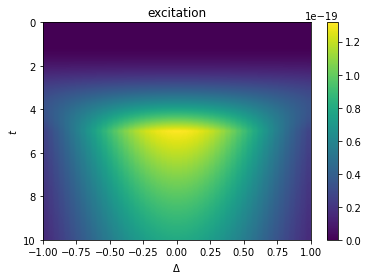

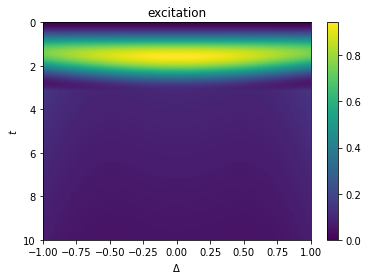

In [166]:
imshow(outA1[:,1,:].real, aspect='auto', extent=[detAx[0], detAx[-1], tSteps[-1], tSteps[0]])
xlabel(r"$\Delta$")
ylabel('$t$')
colorbar()
title('excitation')
figure()
imshow(outA2[:,1,:].real, aspect='auto', extent=[detAx[0], detAx[-1], tSteps[-1], tSteps[0]])
xlabel(r"$\Delta$")
ylabel('$t$')
colorbar()
title('excitation')

In [18]:
zAx = linspace(0,1,30)
detAx = linspace(-1,1,50)
tSteps = linspace(0,10,1000)
EinFw = lambda t: .01 + 0.0j if (t>1) and (t<3) else 0 #where( (tSteps>1) & (tSteps<3), 1.0, 0) 
lhsL, rhsL = h.seperate_DM_equation(eq)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={zS: zAx, DeltaS:detAx }, driving_syms=[EexS], backend='numpy')
polF=sm.lambdify( ode_s.symsD['prop_state_syms'],ex_vals[0] )
zAx = ode_s.dimAxes[0]
dz = zAx[1]-zAx[0]
display(dz)
lineShape= 0.5*ones_like(detAx)/sqrt(detAx.size)*dz

def calcPolFieldF(t, dimAxs, state,  driving, lineShape=lineShape):
    #P = -1j*np.cumsum(polF(*state).T)*dz* lineShape
    P = -1j*np.cumsum( (polF(*state)*lineShape).sum(axis=1), axis=0)
    return P.reshape(dimAxs[0].shape)
#def calcPolFieldF(t, delt, z,rho00, rho11, rho01,Eex):
#    P = -1j*np.cumsum(polF(rho00, rho11, rho01))*dz*1
#    return P
p0 = zeros(ode_s.state_shape)
p0[0] = 1

ode_s.set_driving({EexS:EinFw})
ode_s.set_state_dep_funcs({EinS:calcPolFieldF})
ode_s.set_initial_conditions(p0)
ode_s.setup()
#dy_dtD = h.makeMESymb(hamilParams)

ode_s.integrate(tSteps, 0.01)
outA = np.array(ode_s.outputL)

Munch({'tSym': t, 'dimSyms': [z, Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}], 'stationary_state_syms': [], 'driving_syms': [E_ex], 'state_dep_syms': [Delta, Ef]})
state dependent functions should have signature [t, z, Delta, \rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}, \rho_{0|2}, \rho_{1|2}, E_ex]


Not integrating first step (it's just the initial state)


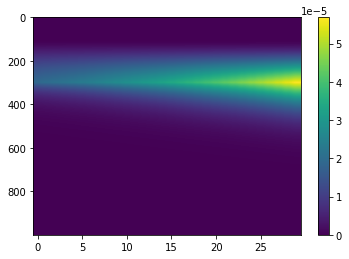

In [19]:
imshow(outA[:,2,:,detAx.size//2].real, aspect='auto')
colorbar()

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '0.034482758620689655')

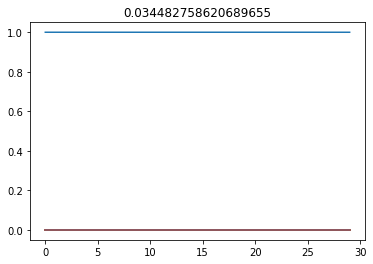

In [20]:
plot(outA[:,:,:,detAx.size//2].mean(axis=0).T)
title(dz)

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '0.034482758620689655')

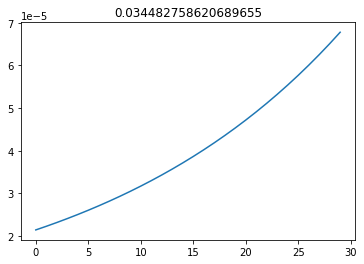

In [21]:
plot(outA[:,1,:,detAx.size//2].mean(axis=0))
title(dz)

In [ ]:
polF=sm.lambdify( ode_s.symsD['prop_state_syms'],ex_vals[0] )
zAx = ode_s.dimAxes[0]
dz = zAx[1]-zAx[0]

#def calcPolFieldF(t, z,rho00, rho11, rho01,Eex):
def calcPolFieldF(t, dimAxs,state,driving):
    #P = -1j*np.cumsum(polF(rho00, rho11, rho01))*dz*1
    P = -1j*np.cumsum(polF(*state))*dz*1
    return P
calcPolFieldF.num=0

ode_s.set_driving({EexS: lambda t: -0.5 if t<20 else 0})
ode_s.set_state_dep_funcs({EinS:calcPolFieldF})
ode_s.set_initial_conditions(np.tile(array([1,0,0]), (100,1) ).T.astype('c16'))
ode_s.prepare_for_integration()

In [82]:
import inspect

def f(a,b=2, c=4):
    return a, b+c**2

In [83]:
sig=inspect.signature(f)

In [91]:
len(sig.parameters)

In [90]:
sig

<Signature (a, b=2, c=4)>

In [92]:
sig.bind_partial?

Signature: sig.bind_partial(*args, **kwargs)
Docstring:
Get a BoundArguments object, that partially maps the
passed `args` and `kwargs` to the function's signature.
Raises `TypeError` if the passed arguments can not be bound.
File:      c:\users\morgan\anaconda3\envs\pymbe\lib\inspect.py
Type:      method


In [95]:
sig.bind_partial(1,c=5)

<BoundArguments (a=1, c=5)>

In [1]:
import qutip as q


In [11]:
q.jmat?

Signature: q.jmat(j, *args)
Docstring:
Higher-order spin operators:

Parameters
----------
j : float
    Spin of operator

args : str
    Which operator to return 'x','y','z','+','-'.
    If no args given, then output is ['x','y','z']

Returns
-------
jmat : qobj / ndarray
    ``qobj`` for requested spin operator(s).


Examples
--------
>>> jmat(1)
[ Quantum object: dims = [[3], [3]], shape = [3, 3], type = oper, isHerm = True
Qobj data =
[[ 0.          0.70710678  0.        ]
 [ 0.70710678  0.          0.70710678]
 [ 0.          0.70710678  0.        ]]
 Quantum object: dims = [[3], [3]], shape = [3, 3], type = oper, isHerm = True
Qobj data =
[[ 0.+0.j          0.-0.70710678j  0.+0.j        ]
 [ 0.+0.70710678j  0.+0.j          0.-0.70710678j]
 [ 0.+0.j          0.+0.70710678j  0.+0.j        ]]
 Quantum object: dims = [[3], [3]], shape = [3, 3], type = oper, isHerm = True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]]


Notes
-----
If no 'args' input, then returns array of 

sx,sy,sz = q.jmat(1.5)

In [9]:
sz - sz.dag()

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [6]:
sx

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.        0.8660254 0.        0.       ]
 [0.8660254 0.        1.        0.       ]
 [0.        1.        0.        0.8660254]
 [0.        0.        0.8660254 0.       ]]

In [12]:
sm = q.jmat(1.5, "-")

In [13]:
sm + sm.dag()

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.         1.73205081 0.         0.        ]
 [1.73205081 0.         2.         0.        ]
 [0.         2.         0.         1.73205081]
 [0.         0.         1.73205081 0.        ]]

In [12]:
sm.SparseMatrix(H0)

⎡0   0 ⎤
⎢      ⎥
⎣0  1.0⎦

In [13]:
H0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}], 'stationary_state_syms': [], 'driving_syms': [E], 'state_dep_syms': []})
state dependent functions should have signature [t, \rho_{0|0}, \rho_{1|1}, \rho_{0|1}, E]
CPU times: user 227 ms, sys: 1 ms, total: 228 ms
Wall time: 250 ms


/home/morgan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


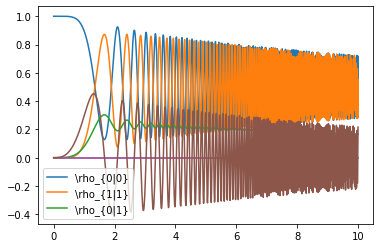

In [7]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS = sm.symbols('t')
ES = sm.symbols("E", complex=True)
H0 = 1*K2*K2.dag()
H1 = K1*K2.dag() #+ K2*K1.dag() 
c_opL = [sqrt(.1)*K1*K2.dag()]
#c_opL = [L(op) for op in c_opL]

H_desc = [H0, [ES, H1], [sm.conjugate(ES), H1.dag()]]
eq, ex_vals=h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1], bReturnMatrixEquation=True)
lhsL, rhsL = h.seperate_DM_equation(eq)
#(diagL,diag_dtL), (cohL, coh_dtL), e_op_L = h.makeMESymb(H_desc, c_opL=c_opL, e_opL = [H1])
if 0:
    display("Bloch equations:")
    display(eq)
    display("Polarisation:")
    display(ex_vals)
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES])#, backend='tensorflow')
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_state_dep_funcs({})
ode_s.set_initial_conditions(np.array([1,0,0]) )
ode_s.setup()

tSteps = linspace(0,10,1000)
%time out=ode_s.integrate(tSteps, 1.0)

plot(tSteps,  np.array(ode_s.outputL).squeeze() )
plot(tSteps,  np.array(ode_s.outputL).squeeze().imag )
legend(ode_s.symsD['prop_state_syms'])

## More scrap

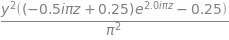

In [59]:

x,y,z, n = sm.symbols("x, y, z, n")
fwM=sm.Function("fwM")(z) #sm.exp(1j*2*sm.pi*z)
fwM = sm.exp(1j*2*sm.pi*z)
ex=sm.integrate(y**2*z*fwM, (z,0,z) ) 
ex.simplify()

In [54]:
lm=sm.lambdify((z,fwM,y), ex, modules='numpy')

In [32]:
sm.summation(z*y**2)

In [50]:
sm.lambdify?

In [55]:
sm.r

In [57]:
lm??

In [61]:
import tensorflow as tf

In [62]:
tf.__version__

'1.13.1'

## Make rho testing

In [165]:
import sympy as sm
from sympy.physics import quantum
import itertools as ito
def makeHermS(M):
    """ Make a symbollic matrix hermitian by mirroring the upper-diagonal elements and conjugating"""
    Nstates=M.shape[0]
    rIL, cIL = np.tril_indices(Nstates, -1)
    rIU, cIU = np.triu_indices(Nstates, 1)
    M=M.subs({M[rl,cl]: sm.conjugate(M[cl,rl]) for ru,cu, rl,cl in zip(rIU, cIU, rIL, cIL)})
    return M

In [183]:
I_tot = 1/2
S_tot = 1/2
N_I = int(2*(I_tot+1)-1)
N_S = int(2*(S_tot+1)-1)
ind_I_L = arange(N_I, dtype='i8')
ind_S_L = arange(N_S, dtype='i8')

rhoI = sm.Matrix(N_I, N_I, sm.symbols("rho^I_0:{0}_0:{0}".format( int(N_I) )) )
rhoS = sm.Matrix(N_S, N_S, sm.symbols("rho^S_0:{0}_0:{0}".format( int(N_S) )) )

In [185]:
rhoSubsD={sm.symbols(r"\rho^I_{{{0}{1}}}".format(k_I1,k_I2))*\
               sm.symbols(r"rho^S_{0}_{1}".format(k_S1,k_S2)):\
              #sm.symbols(r"\rho_\frac{{{0}}}{{2}}_{1}_{2}_{3}".format(k_I1,k_I2,k_S1,k_S2)) \
              sm.symbols(r"rho_{0}_{1}_{2}_{3}".format(k_I1,k_I2,k_S1,k_S2)) \
               for k_I1, k_I2, k_S1,k_S2 in ito.product(ind_I_L, ind_I_L, ind_S_L, ind_S_L) }

rhoM=makeHermS(quantum.TensorProduct(rhoI,rhoS).subs(rhoSubsD))

In [219]:
labels1 = ['0', '1', '2']
labels2 = ['A', 'B']
N = len(labels1) * len(labels2)
rhoS =sm.Array([sm.symbols('\\rho_{{{}{}|{}{}}}'.format(s1,s3,s2,s4)) for s1,s2,s3,s4 in  ito.product(labels1, labels2, labels1, labels2)]).reshape(N,N)

Options for making general matrices (including tensor-ed tensors)
1. get sympy to tensorproduct density matrices, then do a replace by looking at the atoms in each entry.
2. Work out the general formula for each element
3. Do the 2-input algorithm recursivley

In [220]:
makeHermS(rhoS)

⎡\rho_{00|AA}  \rho_{00|AB}  \rho_{01|AA}  \rho_{01|AB}  \rho_{02|AA}  \rho_{0
⎢                                                                             
⎢____________                                                                 
⎢\rho_{00|AB}  \rho_{00|BB}  \rho_{01|BA}  \rho_{01|BB}  \rho_{02|BA}  \rho_{0
⎢                                                                             
⎢____________  ____________                                                   
⎢\rho_{01|AA}  \rho_{01|BA}  \rho_{11|AA}  \rho_{11|AB}  \rho_{12|AA}  \rho_{1
⎢                                                                             
⎢____________  ____________  ____________                                     
⎢\rho_{01|AB}  \rho_{01|BB}  \rho_{11|AB}  \rho_{11|BB}  \rho_{12|BA}  \rho_{1
⎢                                                                             
⎢____________  ____________  ____________  ____________                       
⎢\rho_{02|AA}  \rho_{02|BA}  \rho_{12|AA}  \rho_{12|

In [221]:
list(enumerate(labels1))

[(0, '0'), (1, '1'), (2, '2')]

In [243]:
l=list(ito.product(labels1,labels2))
['{{{0}|{1}}}'.format(el1,el2) for el1, el2 in l]

['{0|A}', '{0|B}', '{1|A}', '{1|B}', '{2|A}', '{2|B}']

In [240]:
list(ito.product(labels2,labels1))

[('A', '0'), ('A', '1'), ('A', '2'), ('B', '0'), ('B', '1'), ('B', '2')]

In [263]:
def getRhoLabels(labels):
    labs=[['{}{}'.format(lab1, lab2) for lab1 in labels] for lab2 in labels]
    return labs

def getTensoredLabels(*args):
    labels_list_list = list(args)
    labels_cur = labels_list_list.pop()
    #labels_ = args.pop()
    mat_labels_cur = getRhoLabels(labels_cur)
    while labels_list_list:
        mat_labels_next = getRhoLabels(labels_list_list.pop())
        mat_labels_cur=_getTensoredLabels(mat_labels_next, mat_labels_cur)
    return mat_labels_cur
    #mat_labelsL = [getRhoLabels(labels) for labels in args]
    #['{}|{}'.format(lab1, lab2) for lab1 in mat2_labels
def _getTensoredLabels(mat_labels1, mat_labels2):
    N1 = len(mat_labels1)
    N2 = len(mat_labels2)
    labelM = np.empty((N1*N2,N1*N2), dtype='O')

    for i1 in arange(N1):
        for k1 in arange(N1):
            for i2 in arange(N2):
                for k2 in arange(N2):
                   labelM[i1*N2+i2, k1*N2+k2] = '{}|{}'.format(mat_labels1[i1][k1], mat_labels2[i2][k2])
        
    return labelM

def getTensoredRhoS(*args ):
    st = '\\rho_{{{}}}'
    labsMat=getTensoredLabels(*args)
    rhoM = np.empty_like(labsMat)
    N = rhoM.shape[0]
    for i in range(N):
        for k in range(N):
            if k < i:
                sym = sm.conjugate(rhoM[k,i]) 
            else:
                sym_st = st.format(labsMat[i,k])
                if k == i :
                    sym = sm.symbols(sym_st, real=True)
                else:
                    sym = sm.symbols(sym_st, real=False)

            rhoM[i, k] = sym
    return sm.Matrix(rhoM)
#getRhoLabels('abc')
getTensoredRhoS('12','ab', 'mn')


⎡\rho_{11|aa|mm}  \rho_{11|aa|nm}  \rho_{11|ba|mm}  \rho_{11|ba|nm}  \rho_{21|
⎢                                                                             
⎢_______________                                                              
⎢\rho_{11|aa|nm}  \rho_{11|aa|nn}  \rho_{11|ba|mn}  \rho_{11|ba|nn}  \rho_{21|
⎢                                                                             
⎢_______________  _______________                                             
⎢\rho_{11|ba|mm}  \rho_{11|ba|mn}  \rho_{11|bb|mm}  \rho_{11|bb|nm}  \rho_{21|
⎢                                                                             
⎢_______________  _______________  _______________                            
⎢\rho_{11|ba|nm}  \rho_{11|ba|nn}  \rho_{11|bb|nm}  \rho_{11|bb|nn}  \rho_{21|
⎢                                                                             
⎢_______________  _______________  _______________  _______________           
⎢\rho_{21|aa|mm}  \rho_{21|aa|mn}  \rho_{21|ab|mm}  

In [252]:

def getTensorProductLabels(labels1,labels2):
    N1 = len(labels1)
    N2 = len(labels2)
    indM = np.empty((N1*N2,N1*N2), dtype='O')

    for i1 in arange(N1):
        for k1 in arange(N1):
            for i2 in arange(N2):
                for k2 in arange(N2):
                   indM[i1*N2+i2, k1*N2+k2] = [(labels1[i1], labels1[k1]),(labels2[i2], labels2[k2]) ] 
    return indM

def getRhoTensorS(labels1, labels2, labels3 ):
    st = '\\rho_{{{0}{1}|{2}{3}}}'#.format(s1,s3,s2,s4)
    #symName = lambda i1, i2: '\\rho_{{{0}|{1}}}'.format(i1,i2)
    #symName = lambda i1, i2: '\\rho_{{{0}{1}|{2}{3}}}'.format(i1,i2)
    N1 = len(labels1)
    
    N2 = len(labels2) *len(labels3)
    l=list(ito.product(labels2,labels3))
    labels2 = ['{{{0}{1}}}'.format(el1,el2) for el1, el2 in l]
    rhoM = np.empty((N1*N2,N1*N2), dtype='O')

    for i1 in arange(N1):
        for k1 in arange(N1):
            for i2 in arange(N2):
                for k2 in arange(N2):
                    i_, k_ = i1*N2+i2, k1*N2+k2
                    if k_ < i_:
                        sym = sm.conjugate(rhoM[k_,i_]) 
                    else:
                        sym_st = st.format(labels1[i1], labels1[k1],labels2[i2], labels2[k2])
                        if k_ == i_ :
                            sym = sm.symbols(sym_st, real=True)
                        else:
                            sym = sm.symbols(sym_st, real=False)
                                         
                    rhoM[i_, k_] = sym  
    return sm.Matrix(rhoM)

    M = np.empty((Nstates,Nstates), dtype='O')
    DI = np.diag_indices(Nstates)
    UI = np.triu_indices(Nstates, 1)
    for inds in zip(*DI):
        M[inds[0], inds[1]] = sm.symbols(symName(*inds), real=True)
    for inds in zip(*UI):
        sym =  sm.symbols(symName(*inds), complex=True)
        M[inds[0], inds[1]] =sym
        M[inds[1], inds[0]] = sm.conjugate(sym)

    return sm.Matrix(M)


In [249]:
getTensorProductLabels('01', 'AB')

array([[list([('0', '0'), ('A', 'A')]), list([('0', '0'), ('A', 'B')]),
        list([('0', '1'), ('A', 'A')]), list([('0', '1'), ('A', 'B')])],
       [list([('0', '0'), ('B', 'A')]), list([('0', '0'), ('B', 'B')]),
        list([('0', '1'), ('B', 'A')]), list([('0', '1'), ('B', 'B')])],
       [list([('1', '0'), ('A', 'A')]), list([('1', '0'), ('A', 'B')]),
        list([('1', '1'), ('A', 'A')]), list([('1', '1'), ('A', 'B')])],
       [list([('1', '0'), ('B', 'A')]), list([('1', '0'), ('B', 'B')]),
        list([('1', '1'), ('B', 'A')]), list([('1', '1'), ('B', 'B')])]],
      dtype=object)

In [248]:
getRhoTensorS('01', 'AB', 'MN')

⎡\rho_{00|{AM}{AM}}  \rho_{00|{AM}{AN}}  \rho_{00|{AM}{BM}}  \rho_{00|{AM}{BN}
⎢                                                                             
⎢__________________                                                           
⎢\rho_{00|{AM}{AN}}  \rho_{00|{AN}{AN}}  \rho_{00|{AN}{BM}}  \rho_{00|{AN}{BN}
⎢                                                                             
⎢__________________  __________________                                       
⎢\rho_{00|{AM}{BM}}  \rho_{00|{AN}{BM}}  \rho_{00|{BM}{BM}}  \rho_{00|{BM}{BN}
⎢                                                                             
⎢__________________  __________________  __________________                   
⎢\rho_{00|{AM}{BN}}  \rho_{00|{AN}{BN}}  \rho_{00|{BM}{BN}}  \rho_{00|{BN}{BN}
⎢                                                                             
⎢__________________  __________________  __________________  _________________
⎢\rho_{01|{AM}{AM}}  \rho_{01|{AN}{AM}}  \rho_{01|{B

In [237]:
sm.Array?

In [179]:
N1 = 2
N2 = 2
ind_mat1 =  []

for  k in range(N1):
    fo

⎡ρ_0_0__I⋅ρ_0_0__S  ρ_0_0__I⋅ρ_0_1__S  ρ_0_1__I⋅ρ_0_0__S  ρ_0_1__I⋅ρ_0_1__S⎤
⎢                                                                          ⎥
⎢________ ________                                                         ⎥
⎢ρ_0_0__I⋅ρ_0_1__S  ρ_0_0__I⋅ρ_1_1__S  ρ_0_1__I⋅ρ_1_0__S  ρ_0_1__I⋅ρ_1_1__S⎥
⎢                                                                          ⎥
⎢________ ________  ________ ________                                      ⎥
⎢ρ_0_1__I⋅ρ_0_0__S  ρ_0_1__I⋅ρ_1_0__S  ρ_1_1__I⋅ρ_0_0__S  ρ_1_1__I⋅ρ_0_1__S⎥
⎢                                                                          ⎥
⎢________ ________  ________ ________  ________ ________                   ⎥
⎣ρ_0_1__I⋅ρ_0_1__S  ρ_0_1__I⋅ρ_1_1__S  ρ_1_1__I⋅ρ_0_1__S  ρ_1_1__I⋅ρ_1_1__S⎦

In [172]:
rhoSubsD

In [2]:
import MT
gauss = MT.gauss


In [4]:
t = linspace(0,1,1000)
y = MT.gauss(t, [1, 0.5, 0.1])
plot(t, y)

#fax = fftfreq(t.size, t[1]-t[0])
#y = 

NameError: name 'linspace' is not defined

# TF testing

In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import tf_interpolator2

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *


#problem definition
K1, K2  = q.basis(2,0), q.basis(2,1), 
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)
H0 = 5*K2*K2.dag()
c_opL = [sqrt(.1)*q.sigmap()]

H_desc = [H0, [ES_r, q.sigmax()], [ES_i, q.sigmay()], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-2,2,100)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1,0,0]) )


tDrv = np.linspace(0,2.1,100)
tDrv -= (tDrv[1]-tDrv[0])/2
def calc_g(drv):
    drv_r, drv_i = drv[:tDrv.size], drv[tDrv.size:]#drv_cmplx.real, drv_cmplx.imag

    tSteps = np.linspace(0,1.99,20)

    with tf.device("/cpu:0"):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            drv_r0 =tf.convert_to_tensor(drv_r, dtype='float64')
            drv_i0 =tf.convert_to_tensor(drv_i, dtype='float64')
            g.watch(drv_r0)
            g.watch(drv_i0)
            drv_r = 5*tf.math.tanh(drv_r0)
            drv_i = 5*tf.math.tanh(drv_i0)

            f_driving_r = tf.function(tf_interpolator2(tDrv, drv_r), experimental_compile=False)
            f_driving_i = tf.function(tf_interpolator2(tDrv, drv_i), experimental_compile=False)

            ode_s.set_driving({ES_r:f_driving_r, ES_i:f_driving_i})
            ode_s.setup(bForceStateDimensions=True)
            #g.watch(p0)

            #arr =ode_s.integrate(tSteps, 1.0)
            tStart = time.time()
            
            arr = ode_s.integrate(tSteps,1.0, method='rk4', solver_options=dict(step_size = (tDrv[1]-tDrv[0])) ) 
            print("time taken: ", tStart-time.time())
            #print(arr.shape)
            #L=tf.pow(tf.reduce_mean(arr[-1,1]), 2)
            L=tf.reduce_mean(arr[-5:-4,0]**2)
            #L = arr[-8:,1, 1]**2
            #L = arr[-5:,1]

    print(L.numpy())
    grad = g.gradient(L, [drv_r0, drv_i0] )
    #grad_i = g.gradient(L, drv_i)

    return arr.numpy(), np.hstack([grad[0].numpy(), grad[1].numpy()]), L







The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{0|1}^r, \rho_{0|1}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x752545d296d0>


In [4]:
y0 = 1.*tDrv*(1+1j)
vals, grad, L =calc_g(np.hstack([y0.real, y0.imag]) )

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.4927794933319092
0.3428455539448771


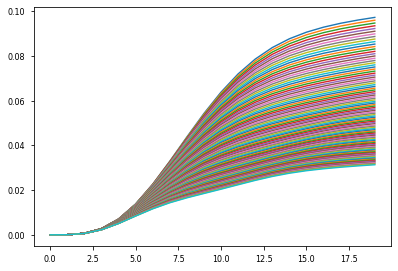

In [171]:
res.shape
plot(res[:,1,:])

In [109]:
y0.size

100

In [198]:
from scipy import optimize
def f(yDrv):
    y, grad, L =calc_g(yDrv)
    return L.numpy().squeeze(), grad
res=optimize.minimize(f, np.hstack([y0.real, y0.imag]) , jac=True)
#res=optimize.minimize(f, res.x , jac=True)

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.649613857269287
0.3428455539448771
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.585284948348999
0.17143706802042744
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5597412586212158
0.05907122438587313
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.4816558361053467
0.04956329910622964
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.123467206954956
0.04475203278570408
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.6092915534973145
0.043522926100682896
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5531361103057861
0.04262404233959918
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5179853439331055
0.041393650628348155
Nevals: <tf.Variable 'Variable:0' shape=()

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.089383363723755
0.0017056856809027645
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5741217136383057
0.0015987830084684626
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.6011862754821777
0.0016794012545452196
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.4975836277008057
0.0015315908741727685
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.0754554271698
0.0016609230773410497
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5555622577667236
0.0015034311476940755
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.587083339691162
0.001457068300918899
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.596468448638916
0.0013934256284091739
Nevals: <tf.Variable 'Variable:

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.0978331565856934
0.0008984323003995145
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5676634311676025
0.000890136075896403
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.575303554534912
0.000879528853932937
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.5675044059753418
0.00087365390918475
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.3898158073425293
0.0008673865769046239
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.6021640300750732
0.0008577008949645735
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.6166272163391113
0.0008451048407958532
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.6201727390289307
0.0008230565172929938
Nevals: <tf.Variable 'Variabl

In [189]:
fin, _, _ =calc_g(res.x )

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -1.590360403060913
0.006618243559740544


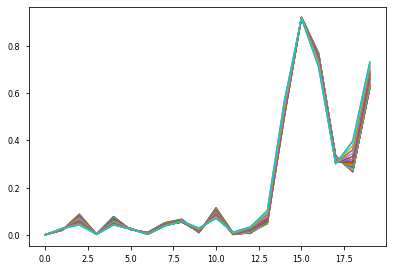

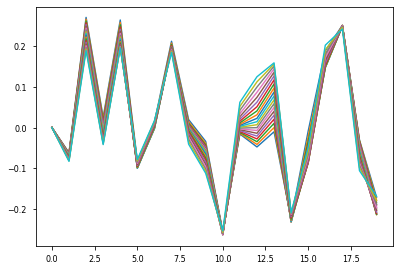

In [190]:
plot(fin[:,1,::5])
plot(fin[:,1,::5])
figure()
plot(fin[:,2,::5])

#plot(fin[:,:,50])

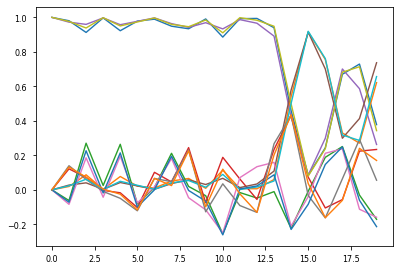

In [191]:
plot(fin[:,:,0])
plot(fin[:,:,-1])
plot(fin[:,:,50])

In [196]:
plot(res.x[:tDrv.size])
plot(res.x[tDrv.size:])
grid()

AttributeError: 'numpy.ndarray' object has no attribute 'x'

In [197]:
res

array([[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.998497  ,  0.99849722,  0.99849744, ...,  0.99853194,
          0.99853244,  0.99853294],
        [ 0.001503  ,  0.00150278,  0.00150256, ...,  0.00146806,
          0.00146756,  0.00146706],
        [-0.02997417, -0.03000602, -0.03003777, ..., -0.03260473,
         -0.03262684, -0.03264883],
        [ 0.02430156,  0.02425776,  0.0242139 , ...,  0.01979241,
          0.01974359,  0.01969473]],

       [[ 0.97700891,  0.97702268,  0.97703662, ...,  0.97911034,
          0.97913935,  0.97916849],
        [ 0.02299109,  0.02297732,  0.02296338, ...,  0.02088966,
          0.

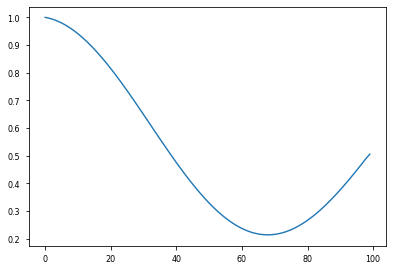

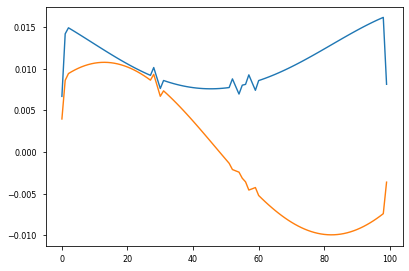

In [78]:
plot(res)

g_r, g_i = grad[:tDrv.size], grad[tDrv.size:]

figure()
plot(g_r)
plot(g_i)

In [40]:
#ode_s.set_driving({ES_r: tf.function(lambda t: -1*t**2), ES_i: tf.function(lambda t: 0*-1*t**2)})
#ode_s.tDepFD
tSteps = np.linspace(0,10,1000)
%time out=ode_s.integrate(tSteps, .5, method='rk4', solver_options=dict(step_size=0.001))

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=40000>
CPU times: user 28.4 s, sys: 1.19 s, total: 29.5 s
Wall time: 29.3 s


In [41]:
tSteps[1]-tSteps[0]

0.01001001001001001

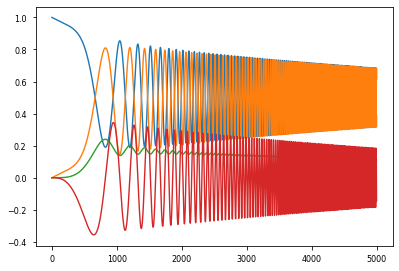

In [37]:
plot(out)

# Optimise 3-level

In [30]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import qutip as q
from spylind import spylind as spl
from spylind import spyIVP as spi
from spylind.tf_misc import tf_interpolator2

from math import *
import numpy as np
import sympy as sm
from matplotlib.pyplot import *


#problem definition
K1, K2, K3  = q.basis(3,0), q.basis(3,1), q.basis(3,2)
tS, DeltaS = sm.symbols('t, Delta', real=True)
ES_r, ES_i = sm.symbols("E_r, E_i", real=True)

H0 = 2*K3*K3.dag() - 2*K1*K1.dag()
c_opL = [sqrt(2.)*K1*K2.dag(), sqrt(2.)*K3*K2.dag()]


a = K1*K2.dag() + K3*K2.dag()
sx = a + a.dag()
sy = 1j*(a.dag()-a)

H_desc = [H0, [ES_r, sx], [ES_i, sy], [DeltaS, K2*K2.dag()] ]
eq, ex_vals=spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [], bReturnMatrixEquation=True)
lhsL, rhsL = spl.seperate_DM_equation(eq)

ode_s = spi.ODESolver(dict(zip(lhsL, rhsL) ),  dims={DeltaS:np.linspace(-1,1,200)}, driving_syms=[ES_r, ES_i], bDecompose_to_re_im=True, backend='tensorflow')
ode_s.set_initial_conditions(np.array([1]+8*[0,0,]) )


tDrv = np.linspace(0,2.1,100)
tDrv -= (tDrv[1]-tDrv[0])/2
def calc_g(drv):
    drv_r, drv_i = drv[:tDrv.size], drv[tDrv.size:]#drv_cmplx.real, drv_cmplx.imag
    drv_r =tf.convert_to_tensor(drv_r, dtype='float64')
    drv_i =tf.convert_to_tensor(drv_i, dtype='float64')
    f_driving_r = tf.function(tf_interpolator2(tDrv, drv_r), experimental_compile=False)
    f_driving_i = tf.function(tf_interpolator2(tDrv, drv_i), experimental_compile=False)

    ode_s.set_driving({ES_r:f_driving_r, ES_i:f_driving_i})
    ode_s.setup(bForceStateDimensions=True)
    tSteps = np.linspace(0,1.99,10)

    with tf.device("/cpu:0"):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            #g.watch(p0)
            g.watch(drv_r)
            g.watch(drv_i)
            #arr =ode_s.integrate(tSteps, 1.0)
            tStart = time.time()
            
            arr = ode_s.integrate(tSteps,1.0, method='rk4', solver_options=dict(step_size = (tDrv[1]-tDrv[0])) ) 
            print("time taken: ", tStart-time.time())
            #print(arr.shape)
            #L=tf.pow(tf.reduce_mean(arr[-1,1]), 2)
            L=tf.reduce_mean(1-arr[-1,2]**2)
            #L = arr[-8:,1, 1]**2
            #L = arr[-5:,1]

    print(L.numpy())
    grad = g.gradient(L, [drv_r, drv_i] )
    #grad_i = g.gradient(L, drv_i)

    return arr.numpy(), np.hstack([grad[0].numpy(), grad[1].numpy()]), L



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Munch({'tSym': t, 'dimSyms': [Delta], 'prop_state_syms': [\rho_{0|0}, \rho_{1|1}, \rho_{2|2}, \rho_{0|1}^r, \rho_{0|1}^i, \rho_{0|2}^r, \rho_{0|2}^i, \rho_{1|2}^r, \rho_{1|2}^i], 'stationary_state_syms': [], 'driving_syms': [E_r, E_i], 'state_dep_syms': [Delta]})
state dependent functions should have signature <itertools.chain object at 0x75251f7c6ac0>


In [36]:
y0 = np.random.normal(size=tDrv.size) + 1j *np.random.normal(size=tDrv.size)
vals, grad, L =calc_g(np.hstack([y0.real, y0.imag]) )

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.1605730056762695
0.9991128607393853


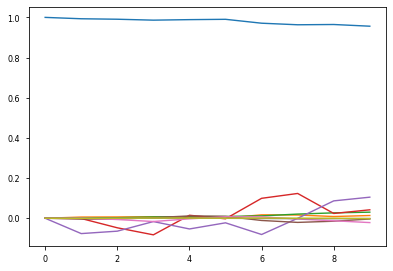

In [37]:
plot(vals[:,:,100])

In [ ]:
from scipy import optimize
def f(yDrv):
    y, grad, L =calc_g(yDrv)
    return L.numpy().squeeze(), grad
res=optimize.minimize(f, np.hstack([y0.real, y0.imag]) , jac=True)
#res=optimize.minimize(f, res.x , jac=True)

/home/morgan/anaconda3/envs/spylind/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.2180709838867188
0.9991128607393853
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.923414945602417
0.9991108527295529
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.9195196628570557
0.9991027837123267
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.817894697189331
0.9990699108769622
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.989755153656006
0.9989285405583952
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.578902006149292
0.998183139392259
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.8727903366088867
0.9908388968937899
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.841519594192505
0.8538858687081524
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.545485258102417
0.39657733442957066
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.1184329986572266
0.39431887563905704
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -4.203845739364624
0.39049617811538384
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.4387710094451904
0.38400279073712595
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.925708770751953
0.3726364600592009
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -4.221186399459839
0.353080818092167
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.101440668106079
0.32761367144073605
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -5.000711917877197
0.31685738846964523
Nevals: <tf.Variable 'Variable:0' shape=() dtype=

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.350200653076172
0.18148074750968085
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.17183780670166
0.18077622207931313
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.0414810180664062
0.179871676330026
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.374485969543457
0.17848862142334357
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.058443069458008
0.1773327261609887
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.088132619857788
0.17686285881730746
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -4.140099763870239
0.17653949779034445
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.7248871326446533
0.17646314562456702
Nevals: <tf.Variable 'Variable:0' shape=() dtype=i

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.1593472957611084
0.11999311357903775
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.121143341064453
0.11968548189738265
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.1375572681427
0.11913766451461438
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.0950796604156494
0.11818549841090015
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.032944440841675
0.11657096790803667
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.0751748085021973
0.11391177545190354
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.0524675846099854
0.11005468660270697
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.206711769104004
0.10771547403700424
Nevals: <tf.Variable 'Variable:0' shape=() dty

Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.8755674362182617
0.05200764395201864
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.896653413772583
0.05115217615155261
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -3.090440273284912
0.05018090704517573
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.874804973602295
0.049540576210477194
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.8485167026519775
0.04886729500889384
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.855469226837158
0.048470591582487295
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.860029935836792
0.0481929714087117
Nevals: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=376>
time taken:  -2.8923027515411377
0.04801582539334756
Nevals: <tf.Variable 'Variable:0' shape=() d

In [ ]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES], bDecompose_to_re_im=True)
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_initial_conditions(dict( zip(ode_s.symsD.prop_state_syms, [1,0,0,0]) ), bRealified=True )
ode_s.set_initial_conditions( [1,0,0], bRealified=False )
ode_s.setup()

In [ ]:
yDrv =tf.convert_to_tensor(yDrv, dtype='float64')
f_driving = tf.function(tf_interpolator2(tDrv, yDrv), experimental_compile=False)

ode_s.set_driving({drvS:f_driving})
ode_s.setup(bForceStateDimensions=True

In [ ]:
ode_s = so.ODESolver(dict(zip(lhsL, rhsL) ),  dims={}, driving_syms=[ES], bDecompose_to_re_im=True)
ode_s.set_driving({ES: lambda t: -t**2})
#ode_s.set_initial_conditions(dict( zip(ode_s.symsD.prop_state_syms, [1,0,0,0]) ), bRealified=True )
ode_s.set_initial_conditions( [1,0,0], bRealified=False )
ode_s.setup()